<a href="https://colab.research.google.com/github/atanilson/Comp702/blob/main/Comp702_Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries

In [14]:
import torch
from torch import nn

# To get data
import requests
import zipfile
from pathlib import Path
import os

# Tranforming data
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [16]:
# Device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Data exploration

## Downlaoding the data

In [3]:
!wget https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1 -O EuroSAT_RGB.zip
!unzip -q EuroSAT_RGB.zip -d "data"
!rm EuroSAT_RGB.zip

--2025-07-01 10:12:33--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘EuroSAT_RGB.zip’

EuroSAT_RGB.zip     100%[===================>]  90.27M  1.52MB/s    in 85s     

2025-07-01 10:13:58 (1.07 MB/s) - ‘EuroSAT_RGB.zip’ saved [94658721/94658721]



In [9]:
data_path = Path("data/")
#data_path.mkdir(parents=True, exist_ok=True)
#!mv EuroSAT_RGB data/
EuroSAT_RGB_path = data_path/"EuroSAT_RGB"

In [11]:
def inspect_datafolder(dir_dataset):
  """Walks though the dataset dir and return the content"""
  for dirpath, dirnames, filenames in os.walk(dir_dataset):
    print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}.")

In [12]:
inspect_datafolder(EuroSAT_RGB_path)

There are 10 folders and 0 images in data/EuroSAT_RGB.
There are 0 folders and 2500 images in data/EuroSAT_RGB/Highway.
There are 0 folders and 2000 images in data/EuroSAT_RGB/Pasture.
There are 0 folders and 3000 images in data/EuroSAT_RGB/Residential.
There are 0 folders and 2500 images in data/EuroSAT_RGB/River.
There are 0 folders and 2500 images in data/EuroSAT_RGB/PermanentCrop.
There are 0 folders and 3000 images in data/EuroSAT_RGB/HerbaceousVegetation.
There are 0 folders and 3000 images in data/EuroSAT_RGB/AnnualCrop.
There are 0 folders and 3000 images in data/EuroSAT_RGB/SeaLake.
There are 0 folders and 2500 images in data/EuroSAT_RGB/Industrial.
There are 0 folders and 3000 images in data/EuroSAT_RGB/Forest.


## Visualising

In [22]:
import random
from PIL import Image

random.seed(42)

# Get the list of all possible paths in the dataset
image_path_list = list(EuroSAT_RGB_path.glob("*/*.jpg"))

# Picking a random image path and getting the clas
random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem # Parent it the path, stem is the end of the folder

# Opening the image
img = Image.open(random_image_path)

# printing caracteriscs
print(f"Randoma image path: {random_image_path}")
print(f"Image class: {random_image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

Randoma image path: data/EuroSAT_RGB/SeaLake/SeaLake_1066.jpg
Image class: SeaLake
Image height: 64
Image width: 64


### Using matplotlib

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

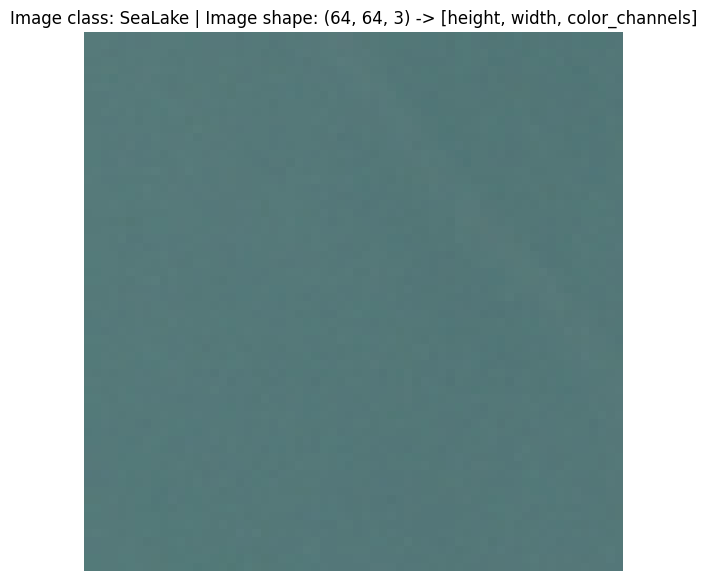

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into an array
img_as_array = np.asanyarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {random_image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## Tranforming

Will perform transformation expermentaly as needed

In [27]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
transform(img).dtype

torch.float32

In [31]:
def plot_tranformed_images(image_path_list, transform, n=3, seed=None):
  """
  Will select random image and load/Tranform
  Then will plot the original vs Tranformed
  """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_path_list, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      # Ploting original
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n Size: {f.size}")
      ax[0].axis(False)

      # Ploting tranfomed
      tranformed_image = transform(f).permute(1, 2, 0) # Change shape because of matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(tranformed_image)
      ax[1].set_title(f"Transformed\n Size: {tranformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

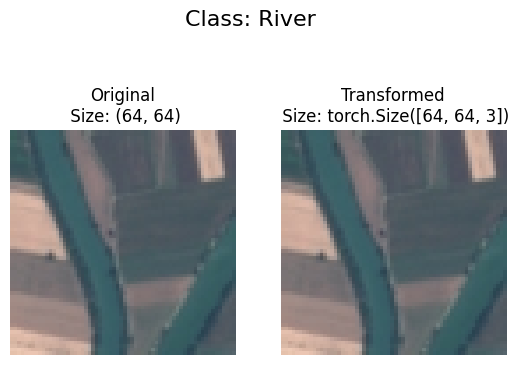

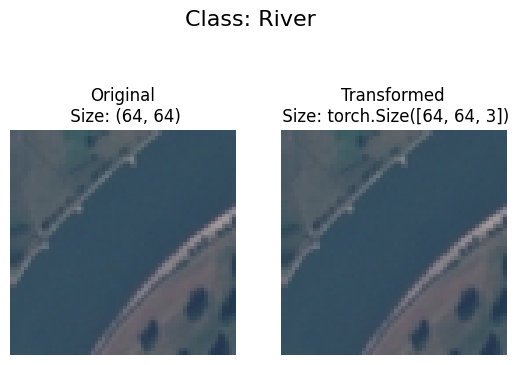

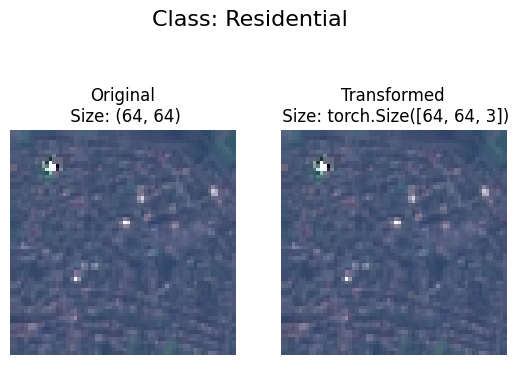

In [32]:
plot_tranformed_images(image_path_list=image_path_list, transform=transform, n=3, seed=None)

### Creating the datset

In [33]:
full_dataset = datasets.ImageFolder(root=EuroSAT_RGB_path, transform=transform)
class_names = full_dataset.classes

train_size = int(0.8*len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [35]:
len(train_dataset), len(test_dataset)

(21600, 5400)

In [37]:
full_dataset

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: data/EuroSAT_RGB
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [45]:
full_dataset.samples[0]

('data/EuroSAT_RGB/AnnualCrop/AnnualCrop_1.jpg', 0)

In [46]:
# Index on the dataset to get a single image and label
img, label = full_dataset[0][0], full_dataset[0][1]
print(f"Image tensor: \n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Lable datatype: {type(label)}")

Image tensor: 
 tensor([[[0.5843, 0.5843, 0.5804,  ..., 0.4000, 0.4078, 0.4039],
         [0.5843, 0.5843, 0.5804,  ..., 0.4000, 0.4078, 0.4039],
         [0.5608, 0.5569, 0.5725,  ..., 0.4000, 0.4000, 0.4039],
         ...,
         [0.5647, 0.5529, 0.5373,  ..., 0.4039, 0.3922, 0.3961],
         [0.5176, 0.5176, 0.4980,  ..., 0.4118, 0.4118, 0.4196],
         [0.4863, 0.4784, 0.4706,  ..., 0.4157, 0.4157, 0.4196]],

        [[0.4745, 0.4745, 0.4667,  ..., 0.3529, 0.3608, 0.3569],
         [0.4745, 0.4745, 0.4667,  ..., 0.3529, 0.3608, 0.3569],
         [0.4588, 0.4549, 0.4588,  ..., 0.3608, 0.3529, 0.3569],
         ...,
         [0.4549, 0.4588, 0.4588,  ..., 0.3647, 0.3529, 0.3569],
         [0.4314, 0.4392, 0.4314,  ..., 0.3686, 0.3647, 0.3725],
         [0.4118, 0.4157, 0.4039,  ..., 0.3725, 0.3686, 0.3725]],

        [[0.4706, 0.4706, 0.4745,  ..., 0.3922, 0.4000, 0.3961],
         [0.4706, 0.4706, 0.4745,  ..., 0.3922, 0.4000, 0.3961],
         [0.4627, 0.4588, 0.4745,  ..., 0.

Text(0.5, 1.0, 'AnnualCrop')

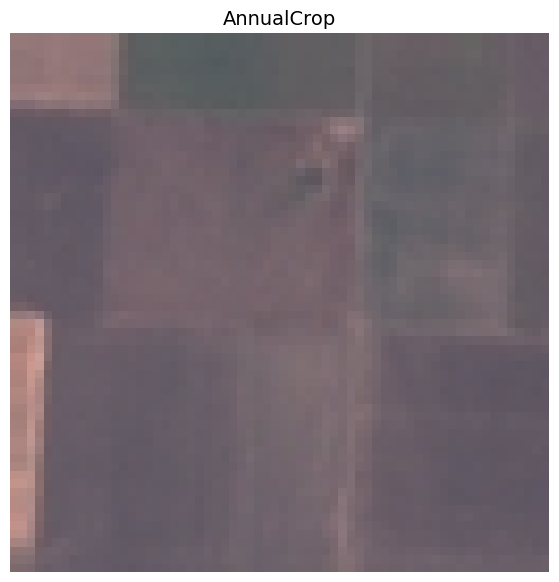

In [47]:
# Printing Image directy from te datasete
img_permute = img.permute(1, 2, 0)

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

### Displaying random image from the dataset

In [77]:
from typing import List
def display_random_images(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):
  # Better if is less tha 10 because of display
  if n>10:
    n=10

  if seed:
    random.seed(seed)

  # 4. Getting random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # Create plot
  plt.figure(figsize=(16, 8))

  # Looping through the index and ploting them
  for i, img_sample_idx in enumerate(random_sample_idx):
    img_sample, label_sample = dataset[img_sample_idx][0], dataset[img_sample_idx][1]

    plt.subplot(1,n, i+1)
    plt.imshow(img_sample.permute(1,2,0))
    plt.axis(False)
    if classes:
      title = (f"Class: {classes[label_sample]}")
      if display_shape:
        title = title + f"\nShape: {img_sample.permute(1,2,0).shape}"
    plt.title(title)

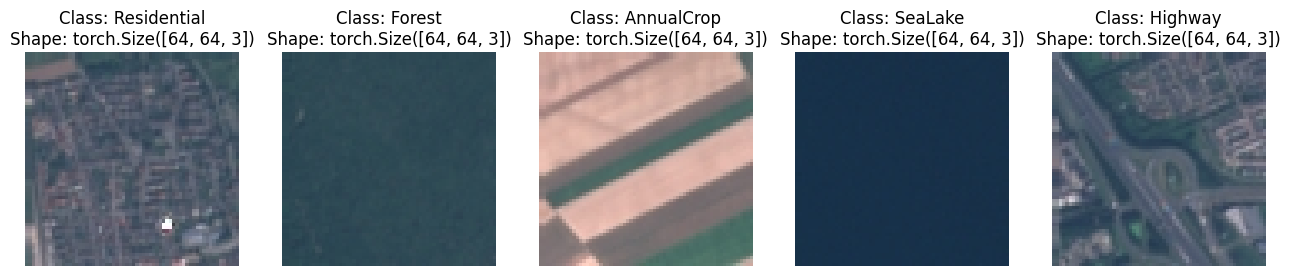

In [78]:
display_random_images(train_dataset.dataset, n=5, classes=class_names, seed=42)

### Creatind Datalaoder

In [48]:
# Datalaoder
BATH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_datalaoder = DataLoader(train_dataset, batch_size=BATH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [49]:
len(train_datalaoder), len(train_dataset)

(675, 21600)

In [50]:
21600/32

675.0

In [51]:
# Loading from the datalaoder
img, label = next(iter(train_datalaoder))
print(f"Image shape: {img.shape}-> [batch_size, color channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64])-> [batch_size, color channels, height, width]
Label shape: torch.Size([32])
